In [1]:
import os

In [2]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
from rnnmorph.predictor import RNNMorphPredictor
from nltk.tokenize import toktok

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [4]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm

In [5]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [6]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [7]:
col_names = list(responses[0])
df = pd.DataFrame()
for col_name in col_names:
    listt = []
    for i in range(len(responses)):
        listt.append(responses[i][col_name])
    tmp = pd.DataFrame(listt,columns=[col_name])
    df = pd.concat([df,tmp], axis=1)
    del tmp
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [8]:
df = df[['city',
         'title',
         'num_comments',
         'bank_name',
         'text',
         'rating_grade']]
df.head()

,city,title,num_comments,bank_name,text,rating_grade
0,г. Москва,Жалоба,0,Бинбанк,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,Не могу пользоваться услугой Сбербанк он-лайн,0,Сбербанк России,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,Двойное списание за один товар.,1,Бинбанк,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,Меняют проценты комиссии не предупредив и не ...,2,Сбербанк России,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,Верните денежные средства за страховку,1,ОТП Банк,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [10]:
# 1. Посчитайте количество отзывов в разных городах и на разные банки
df.groupby(['city','bank_name']).agg({'num_comments':sum}).reset_index().sort_values(by = ['num_comments'],ascending = False)

,city,bank_name,num_comments
7453,г. Москва,Сбербанк России,33488
7489,г. Москва,Тинькофф Банк,25235
7437,г. Москва,Русский Стандарт,14208
7140,г. Москва,Авангард,14022
7160,г. Москва,Альфа-Банк,12993
12394,г. Санкт-Петербург,Сбербанк России,10428
7455,г. Москва,Связной Банк,9438
7206,г. Москва,ВТБ 24,9326
7336,г. Москва,Московский Кредитный Банк,8899
7459,г. Москва,Ситибанк,7821


In [11]:
# 2. Постройте гистограмы длин слов в символах и в словах
df.text.tolist()[1]

'Доброго дня! Являюсь держателем зарплатной карты , выданной Сбербанком России. В 2008 году сменила фамилию, предоставила в банк \xa0документы (копию нового паспорта, свидетельства о браке), мне перевыпустили карту на фамилию мужа ТОКАРЕВА МАРИЯ АЛЕКСАНДРОВНА (девичья \xa0- СЕКЛЕТИНА). \xa0 Возникла необходимость подключить услугу Сбербанк онлайн, НЕ ПОЛУЧИЛОСЬ (на главной странице на отображались мои карты). Связалась с техническим специалистом отделения Сбербанка в котором обслуживалась. Он пояснил, что в базе банка, я все ещё под девичьей фамилией СЕКЛЕТИНА. Предложил выслать сканы необходимых документов. Выслала, оставив контакты, звонка так и не дождалась. Ч/з некоторое время звоню сама, объясняю ситуацию, меня пробивают по базе - опять числюсь СЕКЛЕТИНОЙ (хотя карту уже перевыпустили еще раз на фамилию ТОКАРЕВА в связи с истечением срока обслуживания). Высылаю документы (копию паспорта и свидетельства о браке). Результат \xa0- 0 (ноль). ПРошу помочь разобраться в этой ситуации. С

In [9]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df['rtext'] = df.text.str.lower()
df['rtext'] = df['rtext'].apply(words_only)

text_list = df['rtext'].tolist()

In [13]:
text_list[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности начиная с марта года начали приходить бесконечные письма из ооо примо коллект на мой адрес город москва уваровский переулок дом квартира с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор от года и договор от года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают закон о защи

In [14]:
def word_len_dictionary(word_length, word_len_dict):
    for word_len in word_length:
        if word_len in word_len_dict.keys():
            word_len_dict[word_len]+=1
        else:
            word_len_dict.setdefault(word_len)
            word_len_dict[word_len] = 1
    return word_len_dict
        
def preproc(text, word_len_dict):
    # передаем строку списка
    word_list=[]
    word_list.append(text.split())
    word_length=[]
    for el in word_list[0]:
        word_length.append(len(el))
    return word_len_dictionary(word_length, word_len_dict)

In [15]:
word_len_dict = {}
word_len_dict.clear()
word_len_dict

for text in tqdm(text_list):
    preproc(text,word_len_dict)

100%|██████████| 153499/153499 [00:24<00:00, 6271.50it/s]


In [16]:
list_keys = list(word_len_dict.keys())
list_keys.sort()

In [17]:
keys=[]
values=[]

for i in list_keys:
    keys.append(i)
    values.append(word_len_dict[i])

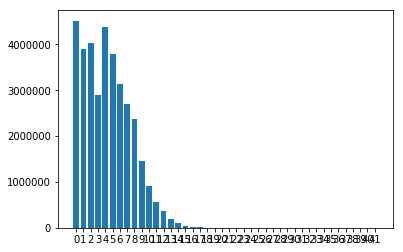

In [19]:
y_pos = np.arange(len(keys))

plt.bar(y_pos, values, align='center', alpha=1)
plt.xticks(y_pos, range(len(values)))

 
plt.show()

In [20]:
# 3. Найдите 10 самых частых:
#     * слов
#     * слов без стоп-слов
#     * лемм 

from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('в', 1157262)
('и', 965735)
('не', 808409)
('на', 632541)
('что', 586864)
('я', 427944)
('с', 423586)
('по', 333342)
('-', 294086)
('мне', 277035)


In [10]:
from nltk.corpus import stopwords
#print(stopwords.words('russian'))
mystopwords = stopwords.words('russian') + ['это','т', 'очень']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [22]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text']
    tokens = words_only(tokens, regex=regex).lower()
    tokens = remove_stopwords(tokens, mystopwords = mystopwords)
    tokens = tokens.split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('отделение', 66647)


In [32]:
predictor = RNNMorphPredictor(language="ru")
toktok = toktok.ToktokTokenizer()

In [11]:
from sklearn.model_selection import train_test_split

In [33]:
sample_train,sample_test  = train_test_split(df, test_size=0.01, random_state=42)

In [30]:
len(sample_test)

1535

In [33]:
%%time
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(sample_test.iterrows(), total = len(sample_test)):
    tokens = row['text']
    tokens = words_only(tokens, regex=regex).lower()
    tokens = remove_stopwords(tokens, mystopwords = mystopwords)
    tokens = toktok.tokenize(words_only(tokens), return_str=True)
    forms = predictor.predict(tokens.split())
    lemmas3  = [form.normal_form for form in forms]
    cnt.update(lemmas3)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)


('банк', 5574)
('карта', 3652)
('день', 1692)
('мой', 1660)
('деньга', 1626)
('год', 1598)
('отделение', 1497)
('кредит', 1404)
('который', 1348)
('сотрудник', 1299)
CPU times: user 15min 10s, sys: 7min, total: 22min 11s
Wall time: 13min 14s


In [34]:
# 4. существительных

In [35]:
%%time
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(sample_test.iterrows(), total = len(sample_test)):
    tokens = row['text']
    tokens = words_only(tokens, regex=regex).lower()
    tokens = remove_stopwords(tokens, mystopwords = mystopwords)
    tokens = toktok.tokenize(words_only(tokens), return_str=True)
    forms = predictor.predict(tokens.split())
    lemmas3  = [form.normal_form for form in forms if form.pos == 'NOUN']
    cnt.update(lemmas3)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)


('банк', 5574)
('карта', 3648)
('день', 1692)
('деньга', 1625)
('год', 1539)
('отделение', 1497)
('кредит', 1404)
('сотрудник', 1299)
('клиент', 1281)
('счёт', 1245)
CPU times: user 15min 20s, sys: 7min 3s, total: 22min 23s
Wall time: 13min 56s


In [36]:
# 5. Постройте кривые Ципфа и Хипса (урезал датафрейм - выч. мощностей не хватает)
### Закон Ципфа

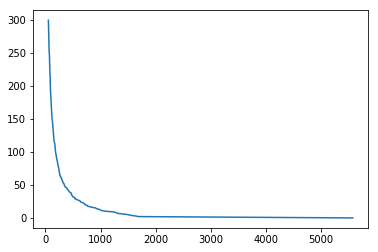

In [37]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [38]:
### Закон Хипса

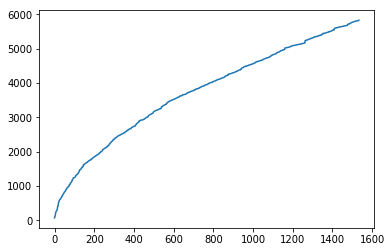

In [39]:
fig, ax = plt.subplots()
ax.plot(n_types)
plt.show()

In [40]:
#    Данные , возможно, не соотетствуют действительности, т.к. считал на уроезанном ДФ

# 6. Ответьте на следующие вопросы:
#     * какое слово встречается чаще, "сотрудник" или "клиент"?
#     * сколько раз встречается слова "мошенничество" и "доверие"?

cnt['сотрудник'], cnt['клиент'], cnt['мошенничество'], cnt['доверие']

(1299, 1281, 44, 25)

###### чаще встречается слово 'сотрудник'
###### "мошенничество" - 44 раза и "доверие" - 25

In [41]:
# 7. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. 
#    Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для 
#    положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [15]:
df.columns

Index(['city', 'title', 'num_comments', 'bank_name', 'text', 'rating_grade',
       'rtext'],
      dtype='object')

In [16]:
rdf = df[(df.rating_grade==1)|(df.rating_grade==5)][['title', 'rating_grade','text','rtext']]
rdf.head()

,title,rating_grade,text,rtext
19,Некомпетентность сотрудников банка,1.0,Открыт вклад и счет в USD. Плюс к этому есть з...,открыт вклад и счет в плюс к этому есть зарпла...
33,Навязывание страховки,1.0,Доброго времени! Вчера мне поступило смс-уведо...,доброго времени вчера мне поступило смс уведом...
76,Нарушение договора банковского вклада,1.0,"05.06.2015г. около 15 часов, пришел в указанны...",г около часов пришел в указанный офис с намере...
85,"Невозможно оплатить отчисления на капремонт ""Т...",1.0,Для оплаты коммунальных платежей пользуюсь пла...,для оплаты коммунальных платежей пользуюсь пла...
94,Некомпетентность сотрудника Сбербанка при пров...,1.0,В апреле этого года пришла в отделение сбербан...,в апреле этого года пришла в отделение сбербан...


In [17]:
rdf.rating_grade.value_counts()

1.0    47387
5.0    14713
Name: rating_grade, dtype: int64

In [18]:
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "
    
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'год']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [31]:
tokens_by_topic = []
for grade in rdf['rating_grade'].unique():
    print(grade)
    tokens = []
    sample = rdf[rdf.rating_grade==grade].sample(n=500)
    sample.text = sample.rtext.str.lower() 
    #print(sample.text)
    sample.text = sample.text.apply(words_only)    
    #print(sample.text)
    sample.text = sample.text.apply(remove_stopwords)     
    #print(sample.text)
    sample.text = sample.text.apply(lemmatize)    
    #print(sample.text)
    sample.text = sample.text.apply(remove_stoplemmas) 
    #print(sample.text)
    for i in range(len(sample)):
        tokens += sample.text.iloc[i].split()
    tokens_by_topic.append(tokens)

1.0
5.0


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking = []
dense = tfidf_matrix.todense()

In [16]:
topic_id = 0
rdf['rating_grade'].unique()[topic_id]

1.0

In [17]:
rankings = pd.DataFrame()
ind = 0
for grade in rdf['rating_grade'].unique():
    tfidf_ranking = []
    text = dense[ind].tolist()[0]
    ind+=1
    phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    phrases = []
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:10]:
        tfidf_ranking.append(phrase)
    rankings = pd.concat([rankings, pd.DataFrame({'tf-idf-{}'.format(grade): tfidf_ranking})],axis = 1)

In [18]:
rankings

,tf-idf-1.0,tf-idf-5.0
0,банк,банк
1,карта,карта
2,деньги,отделение
3,день,день
4,мой,клиент
5,отделение,кредит
6,кредит,деньги
7,счет,вклад
8,клиент,мой
9,сотрудник,сотрудник


In [33]:
%%time 
import nltk
from nltk.collocations import *
N_best = 100 # число извлекаемых биграм

bigram_measures = nltk.collocations.BigramAssocMeasures() # класс для мер ассоциации биграм


CPU times: user 37 µs, sys: 1 µs, total: 38 µs
Wall time: 43.4 µs


In [20]:
_id = 0
finder = BigramCollocationFinder.from_words(tokens_by_topic[_id]) # класс для хранения и извлечения биграм
finder.apply_freq_filter(3) # избавимся от биграм, которые встречаются реже трех раз
raw_freq_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.raw_freq, N_best)] # выбираем топ-10 биграм по частоте 
tscore_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.student_t, N_best)] # выбираем топ-100 биграм по каждой мере 
pmi_ranking =  [' '.join(i) for i in finder.nbest(bigram_measures.pmi, N_best)]
llr_ranking = [' '. join(i) for i in finder.nbest(bigram_measures.likelihood_ratio, N_best)]
chi2_ranking =  [' '.join(i) for i in finder.nbest(bigram_measures.chi_sq, N_best)]

rankings1 = pd.DataFrame({ 'chi2': chi2_ranking, 'llr':llr_ranking, 't-score' : tscore_ranking, 'pmi': pmi_ranking, 'raw_freq':raw_freq_ranking})
rankings1 = rankings1[['raw_freq', 'pmi', 't-score', 'chi2', 'llr']]
rankings1.head(10)

,raw_freq,pmi,t-score,chi2,llr
0,сотрудник банк,бюджетный ассигнование,сотрудник банк,бюджетный ассигнование,денежный средство
1,денежный средство,онл йн,денежный средство,онл йн,колл центр
2,написать заявление,павловский посад,написать заявление,павловский посад,горячий линия
3,кредитный карта,чешский авиалиния,кредитный карта,фунт стерлинг,написать заявление
4,отделение банк,коллекторский агентство,колл центр,чешский авиалиния,досрочный погашение
5,ваш банк,об ме,отделение банк,ростов дон,служба поддержка
6,интернет банк,усть цильма,интернет банк,детский сад,кредитный карта
7,клиент банк,акб инвестторгбанк,досрочный погашение,русский стандарт,русский стандарт
8,колл центр,пожимать плечо,ваш банк,коллекторский агентство,добрый день
9,досрочный погашение,штрафной санкция,горячий линия,об ме,сотрудник банк


In [21]:
_id = 1
finder = BigramCollocationFinder.from_words(tokens_by_topic[_id]) # класс для хранения и извлечения биграм
finder.apply_freq_filter(3) # избавимся от биграм, которые встречаются реже трех раз
raw_freq_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.raw_freq, N_best)] # выбираем топ-10 биграм по частоте 
tscore_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.student_t, N_best)] # выбираем топ-100 биграм по каждой мере 
pmi_ranking =  [' '.join(i) for i in finder.nbest(bigram_measures.pmi, N_best)]
llr_ranking = [' '. join(i) for i in finder.nbest(bigram_measures.likelihood_ratio, N_best)]
chi2_ranking =  [' '.join(i) for i in finder.nbest(bigram_measures.chi_sq, N_best)]

rankings5 = pd.DataFrame({ 'chi2': chi2_ranking, 'llr':llr_ranking, 't-score' : tscore_ranking, 'pmi': pmi_ranking, 'raw_freq':raw_freq_ranking})
rankings5 = rankings5[['raw_freq', 'pmi', 't-score', 'chi2', 'llr']]
rankings5.head(10)

,raw_freq,pmi,t-score,chi2,llr
0,кредитный карта,форс мажор,кредитный карта,венера талгатовна,кредитный карта
1,интернет банк,программный комплекс,интернет банк,вестерн юнион,колл центр
2,другой банк,венера талгатовна,другой банк,форс мажор,интернет банк
3,сотрудник банк,вестерн юнион,сотрудник банк,санкт петербург,денежный средство
4,клиент банк,земляной вал,открывать вклад,горячий линия,горячий линия
5,открывать вклад,ложка деготь,следующий день,программный комплекс,рабочий день
6,отделение банк,северный казна,рабочий день,швейцарский франк,процентный ставка
7,следующий день,небо земля,являться клиент,нижний новгород,следующий день
8,рабочий день,швейцарский франк,колл центр,земляной вал,открывать вклад
9,являться клиент,обеденный перерыв,клиент банк,ложка деготь,приятно удивлять


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [90]:
df_r = df.iloc[:1000]

In [91]:
from gensim.corpora import *
df_r.sort_values(by = ['title'], inplace = True)

#corpus_sample_train = pd.DataFrame(columns=df_r.columns)

/home/dmitry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [92]:
df_rr = pd.DataFrame()
for cl in df_r['title'].unique():
    corpus_sample = df[df['title']==cl]
    if len(corpus_sample) > 100:
        df_rr = pd.concat([df_rr,corpus_sample])
corpus_sample_train = pd.DataFrame(columns=df_rr.columns)

In [93]:
df_rr.shape

(2701, 7)

In [94]:
for cl in df_rr['title'].unique():
    corpus_sample = df_rr[df_rr['title']==cl]
    if len(corpus_sample) > 100:
        print(cl)
        sample = corpus_sample.iloc[:101,:]
        sample.text = sample.text.str.lower()
        sample.text = sample.text.apply(words_only)
        sample.text = sample.text.apply(remove_stopwords) 
        sample.text = sample.text.apply(lemmatize)
        sample.text = sample.text.apply(remove_stoplemmas) 
        corpus_sample_train = corpus_sample_train.append(sample)

Благодарность
Жалоба
Звонки
Звонки из банка
Кредит
Кредитная карта
Обслуживание
Открытие вклада
Потребительский кредит
Претензия
Реструктуризация
Страховка
Телефонный терроризм
Ужасное обслуживание
Хороший банк


In [96]:
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models

In [97]:
texts = [df.text.iloc[i].split() for i in range(len(corpus_sample_train))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [98]:
ldamodel = models.ldamodel.LdaModel(corpus, id2word = dictionary, num_topics = 10, passes = 20, alpha = 1.25, eta = 1.25)

In [99]:
for t, top_words in ldamodel.print_topics(num_topics = 10, num_words=10):
    print('title '+str(t)+' : '+str(top_words))

title 0 : 0.000*"и" + 0.000*"не" + 0.000*"в" + 0.000*"что" + 0.000*"по" + 0.000*"на" + 0.000*"с" + 0.000*"я" + 0.000*"микрорайоне" + 0.000*"мне"
title 1 : 0.026*"в" + 0.023*"и" + 0.019*"не" + 0.015*"на" + 0.013*"что" + 0.010*"с" + 0.010*"я" + 0.009*"по" + 0.007*"мне" + 0.006*"-"
title 2 : 0.000*"в" + 0.000*"и" + 0.000*"не" + 0.000*"на" + 0.000*"что" + 0.000*"с" + 0.000*"по" + 0.000*"я" + 0.000*"о" + 0.000*"мне"
title 3 : 0.000*""АЛЬФА-БАНК"" + 0.000*"(файл:" + 0.000*"(файлы:" + 0.000*"«Люта»" + 0.000*"Ив-енко" + 0.000*"Е.С." + 0.000*"«Люта»." + 0.000*"агентом" + 0.000*"06_СК_ЮАО.jpg" + 0.000*"учете"
title 4 : 0.000*"в" + 0.000*"и" + 0.000*"Железнодорожный" + 0.000*"д.8" + 0.000*"не" + 0.000*"на" + 0.000*"Л-ва" + 0.000*"по" + 0.000*"с" + 0.000*"что"
title 5 : 0.000*"и" + 0.000*"не" + 0.000*"в" + 0.000*"на" + 0.000*"что" + 0.000*"с" + 0.000*"я" + 0.000*"по" + 0.000*"микрорайоне" + 0.000*"мне"
title 6 : 0.000*"в" + 0.000*"и" + 0.000*"что" + 0.000*"не" + 0.000*"на" + 0.000*"с" + 0.000*"по"

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *

from sklearn.model_selection import train_test_split
# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])

#clf = Pipeline([ 
#    ('vect', CountVectorizer()), 
#    ('tfidf', TfidfTransformer()), 
#    ('tm', TruncatedSVD()), 
#    ('clf', RandomForestClassifier())
#])

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое. 

In [20]:
rdf.rating_grade.value_counts()

1.0    47387
5.0    14713
Name: rating_grade, dtype: int64

In [21]:
rdf1 = rdf[rdf.rating_grade==1].sample(14713)
rdf5 = rdf[rdf.rating_grade==5]
rdf15 = pd.concat([rdf1,rdf5])
rdf15.rating_grade.value_counts()

5.0    14713
1.0    14713
Name: rating_grade, dtype: int64

In [22]:
train,test  = train_test_split(rdf15, test_size=0.3, random_state=2)
train_X = train.drop('rating_grade', axis=1)
train_y = train.rating_grade
test_X  = test.drop('rating_grade', axis=1)
test_y  = test.rating_grade

Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных 𝑛-грам. 

In [23]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('clf', RandomForestClassifier()),
])

clf.fit(train_X.iloc[:5000].rtext, train_y.iloc[:5000])

true = test_y.iloc[5001:6000]
predictions = clf.predict(test_X.iloc[5001:6000].rtext)

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))
labels = clf.classes_

/home/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.85
Recall:   0.84
F1-measure:   0.85
Accuracy:   0.85
              precision    recall  f1-score   support

         1.0       0.81      0.91      0.86       516
         5.0       0.89      0.78      0.83       483

   micro avg       0.85      0.85      0.85       999
   macro avg       0.85      0.84      0.85       999
weighted avg       0.85      0.85      0.85       999



In [63]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word')),
    ('clf', RandomForestClassifier()),
])

clf.fit(train_X.rtext, train_y)

true = test_y
predictions = clf.predict(test_X.rtext)

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))
labels = clf.classes_

/home/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.86
Recall:   0.86
F1-measure:   0.86
Accuracy:   0.86
              precision    recall  f1-score   support

         1.0       0.82      0.93      0.87      4459
         5.0       0.91      0.79      0.85      4369

   micro avg       0.86      0.86      0.86      8828
   macro avg       0.86      0.86      0.86      8828
weighted avg       0.86      0.86      0.86      8828



In [43]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', ngram_range={1,2})),
    ('clf', RandomForestClassifier()),
])

clf.fit(train_X.rtext, train_y)

true = test_y
predictions = clf.predict(test_X.rtext)

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))
labels = clf.classes_

/home/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.85
Recall:   0.84
F1-measure:   0.84
Accuracy:   0.84
              precision    recall  f1-score   support

         1.0       0.79      0.92      0.85      4459
         5.0       0.90      0.75      0.82      4369

   micro avg       0.84      0.84      0.84      8828
   macro avg       0.85      0.84      0.84      8828
weighted avg       0.85      0.84      0.84      8828



In [44]:
clf = Pipeline([
    ('vect', CountVectorizer(analyzer = 'word', ngram_range={1,3})),
    ('clf', RandomForestClassifier()),
])

clf.fit(train_X.rtext, train_y)

true = test_y
predictions = clf.predict(test_X.rtext)

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))
labels = clf.classes_

/home/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.84
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83
              precision    recall  f1-score   support

         1.0       0.79      0.91      0.85      4459
         5.0       0.89      0.76      0.82      4369

   micro avg       0.83      0.83      0.83      8828
   macro avg       0.84      0.83      0.83      8828
weighted avg       0.84      0.83      0.83      8828



3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

In [24]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])
clf.fit(train_X.rtext, train_y)

true = test_y
predictions = clf.predict(test_X.rtext)

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
#print(classification_report(true, predictions))
#labels = clf.classes_

/home/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.81
Recall:   0.81
F1-measure:   0.81
Accuracy:   0.81


In [25]:
from sklearn.decomposition import LatentDirichletAllocation
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('LDA', LatentDirichletAllocation(n_components=100)), 
    ('clf', RandomForestClassifier())
])
clf.fit(train_X.iloc[:500].rtext, train_y.iloc[:500])

true = test_y.iloc[:100]
predictions = clf.predict(test_X.iloc[:100].rtext)

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))

/home/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Precision:   0.55
Recall:   0.55
F1-measure:   0.55
Accuracy:   0.55


Всего 100 токенов объясняют 55 % данных.
Больше данных использовать не получилось, т.к. вылезает ошибка MemoryError.